In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import vice

from surp import gce_math as gcem
from surp._globals import AGB_MODELS
from surp import subgiants
import surp
import arya


/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
#plt.rcParams["text.usetex"] = False

In [3]:
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    "S16/W18": [0],
    "S16/W18F": [0],
    "CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    "CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }

M_max = {
    "LC18": 120,
    "S16/N20": 120,
    "S16/W18": 120,
    "S16/W18F": 120,
    "NKT13": 40,
    "WW95": 40,
    "CL04": 35,
    "CL13": 120,
}

ccsne_studies = ["LC18", "LC18", "S16/W18F", "S16/W18", "NKT13", "WW95"]
colors = [arya.style.COLORS[i] for i in [0,0,1,1,2,3,4]]
markers = ["o", "o", "s", "d", "*", "^"]
sizes = [30, 30,30, 30,30,30]
rotations = [0, 300, 0, 0, 0, 0]
N = len(ccsne_studies)

labels = [r"LC18, $v_{\rm rot}=0\;{\rm km\,s^{-1}}$", 
          r"LC18, $v_{\rm rot}=300\;{\rm km\,s^{-1}}$",
          "S16/All explode", 
          "S16/W18", 
          "NKT13", 
          "WW95"]

/tmp/ipykernel_231810/1258856170.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,


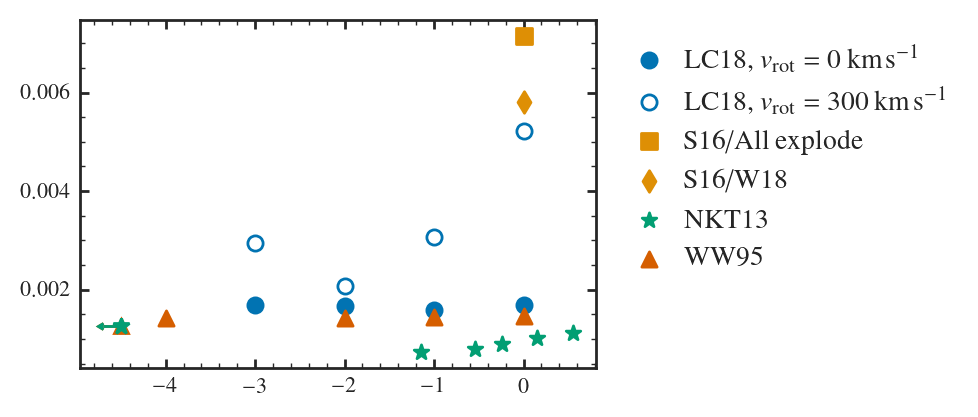

In [4]:
def plot_y_cc(ele='c', ele2=None, **kwargs):
    for i in range(N):
        study=ccsne_studies[i]
        metalicities = allowed_MoverH[study]
        m_upper = M_max[study]

        rotation = rotations[i]

        y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper, **kwargs)[0]
             for metalicity in metalicities]
        if ele2 is not None:
            y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity, 
                rotation=rotation, m_upper=m_upper)[0]
                 for metalicity in metalicities])
            y = np.log10(y/y2) - np.log10(vice.solar_z(ele)/vice.solar_z(ele2))

        marker = markers[i]
        color =facecolor= colors[i]
        label = labels[i]
        if np.isinf(metalicities[0]):
            if study == "WW95":
                x0 = -4.5
                y0 = -0.000
                ms = 5
                zorder = 2
            else:
                x0 = -4.5
                y0 = 0
                ms = 6
                zorder = 3
            plt.errorbar(x0, y[0] + y0, xerr=[0.2], fmt=marker, color=color, 
                         xuplims=[1],ms=ms, zorder=zorder, capsize=0)
            x = metalicities[1:]
            y = y[1:]
        else:
            x = metalicities

        if rotation == 150:
            facecolor=(1,1,1,0)
        if rotation == 300:
            facecolor=(1,1,1,0)

        plt.scatter(x, y, ec=color, label=label,
                    lw=1, fc=facecolor, 
                     marker=marker, s=sizes[i])

plot_y_cc()
arya.Legend(-1)

In [28]:
y_z0 = lambda z: 1e-3
y_z1 = np.vectorize(lambda z: -1/np.log(10)*y_z0(z) + surp.yield_models.Lin_CC(y0=0.001/np.log(10), zeta=0.001)(z))
#y_z2 = np.vectorize(surp.yield_models.Quadratic_CC(y0=0, zeta=0, A=0.001, Z1=0.00176))


def plot_y_cc_mcmc(samples, thin=100, M_H=np.linspace(-0.5, 0.5, 1000), color="black", alpha=None):
    Z = gcem.MH_to_Z(M_H)
    if alpha is None:
        alpha = 1 / (len(samples)/thin)**(1/3) / 10
        
    ys_z0 = y_z0(Z)
    ys_z1 = y_z1(Z)
    ys_z2 = y_z2(Z)
    ymg = vice.yields.ccsne.settings["mg"]

    for i, sample in samples[::thin].iterrows():
        yt = sample.y0_cc * ys_z0 + sample.zeta_cc * ys_z1 #+ sample.A_cc * ys_z2 
        plt.plot(M_H, yt , color=color, alpha=alpha, rasterized=False)
    

def plot_c_mg_mcmc(samples, thin=100, M_H=np.linspace(-0.5, 0.5, 1000), color="black", alpha=None):
    Z = gcem.MH_to_Z(M_H)
    if alpha is None:
        alpha = 1 / (len(samples)/thin)**(1/3) / 10
        
    ys_z0 = y_z0(Z)
    ys_z1 = y_z1(Z)
    ys_z2 = y_z2(Z)
    ymg = vice.yields.ccsne.settings["mg"]

    for i, sample in samples[::thin].iterrows():
        yt = sample.y0_cc * ys_z0 + sample.zeta_cc * ys_z1 #+ sample.A_cc * ys_z2 
        plt.plot(M_H, gcem.abund_ratio_to_brak(yt / ymg, "c", "mg"), color=color, alpha=alpha, rasterized=False)


In [24]:
samples = pd.read_csv("../models/perturbations/mc_analysis/linlinear/mcmc_samples.csv")

In [ ]:
gcem.brak_to_abund_ratio(-0.6, "c", "mg") * y_mg

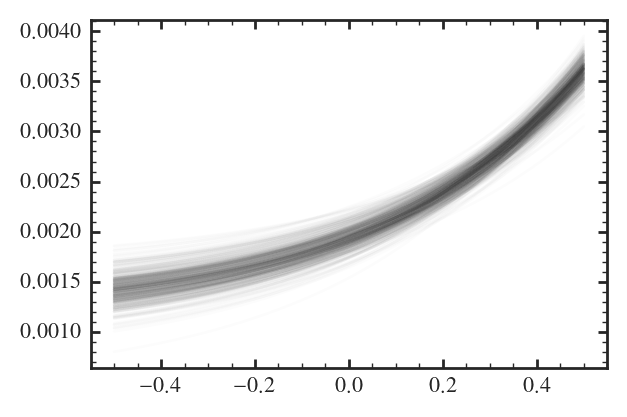

In [25]:
plot_y_cc_mcmc(samples)

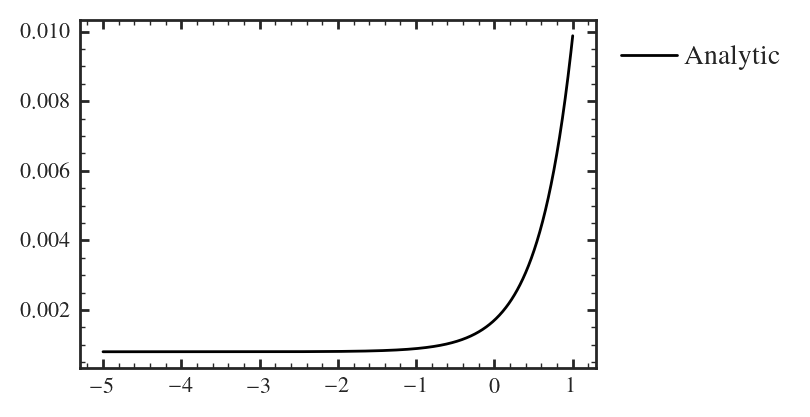

In [26]:
surp.yields.set_yields(surp.YieldParams.from_file("../models/new_fiducial/yield_params.toml"), verbose=False)

y_c_cc = vice.yields.ccsne.settings["c"]

# surp.yields.set_yields(surp.YieldParams.from_file("../models/fruity/cc_BiLogLin/yield_params.toml"), verbose=False)
# y_c_cc2 = vice.yields.ccsne.settings["c"]


def plot_analy():
    m_h = np.linspace(-5, 1, 1000)
    Z = gcem.MH_to_Z(m_h)
    plt.plot(m_h, [y_c_cc(z) for z in Z], color="k", ls="-", zorder=-2, label="Analytic")
    #plt.plot(m_h, [y_c_cc2(z) for z in Z], color="k", ls="--", zorder=-2)

    
plot_analy()
arya.Legend(-1)

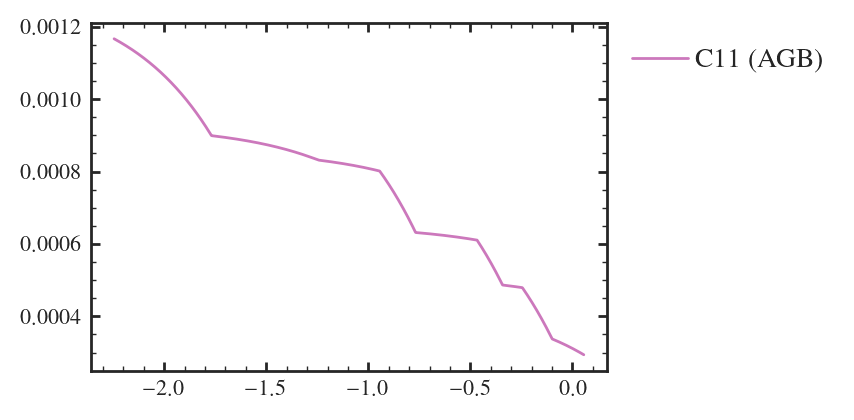

In [21]:
def plot_c11():
    vice.yields.agb.settings["c"] = surp.agb_interpolator.interpolator("c", study="cristallo11")
    vice.yields.ccsne.settings["c"] = 0
    
    y, m, z = vice.yields.agb.grid("c")
    

    mh_min = gcem.Z_to_MH(np.min(z))
    mh_max = gcem.Z_to_MH(np.max(z))

    MH = np.linspace(mh_min, mh_max, 1000)
    Zs = gcem.MH_to_Z(MH)

    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z, mstar=1)
        mass_yields.append(m_c[-1])
        
    line, = plt.plot(MH, (np.array(mass_yields)), label="C11 (AGB)", color=colors[-1])
    
plot_c11()

arya.Legend(-1)

/tmp/ipykernel_231810/1258856170.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/ipykernel_231810/1258856170.py:13: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity,


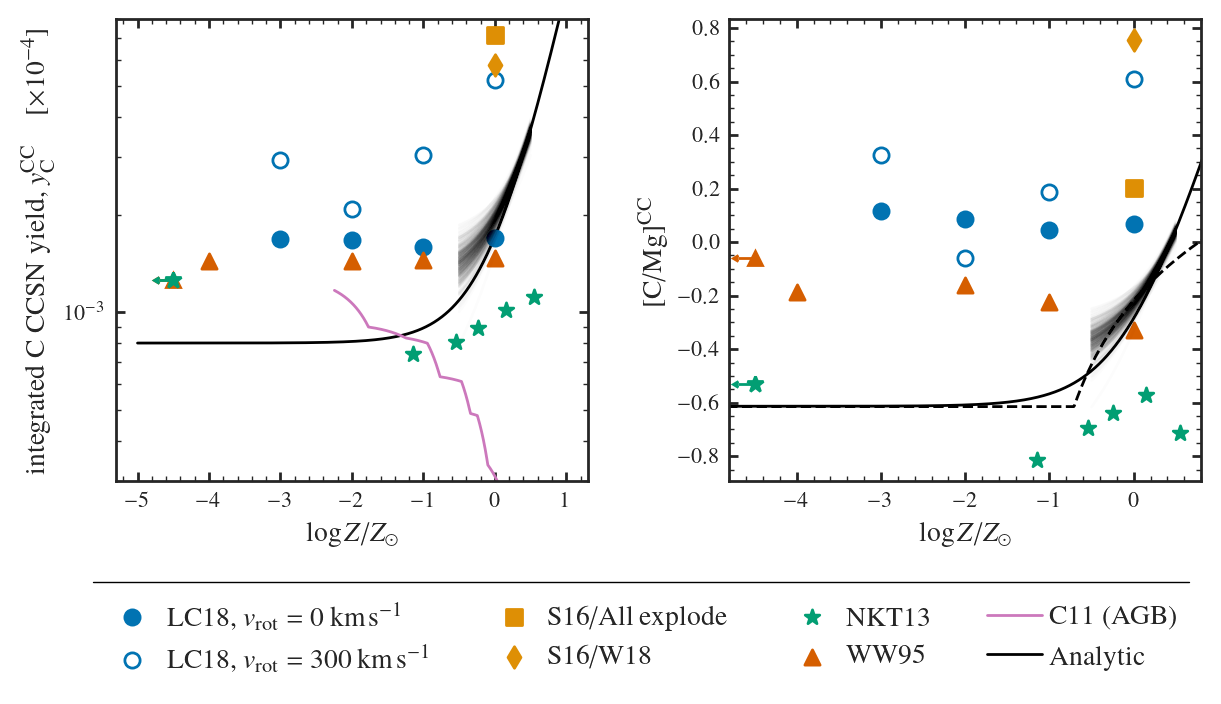

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw={"wspace": 0.3})


# left panel
plt.sca(axs[0])

plot_y_cc()
plot_c11()

plot_analy()
# plot AGB line
plot_y_cc_mcmc(samples)
plt.yscale("log")

plt.xlabel(r"$\log Z/Z_{\odot}$")

y_scale = 1e4
plt.ylabel(r"integrated C CCSN yield, $y_{\rm C}^{\rm CC}\quad [\times 10^{-4}]$")

plt.ylim(3e-4, 0.008)

lines, labs = axs[0].get_legend_handles_labels()

# c = np.arange(0, 0.0081, 0.001)
# plt.yticks(ticks=c, labels=np.int32(np.round(y_scale*c, 0)))



# right panel
plt.sca(axs[1])

plot_y_cc(ele2="mg")
m_h = np.linspace(-5, 1, 1000)
Z = gcem.MH_to_Z(m_h)
y_mg = vice.yields.ccsne.settings["mg"]
y = gcem.abund_ratio_to_brak([y_c_cc(z)/y_mg for z in Z], "c", "mg")
plt.plot(m_h, y, color="k")

y = gcem.abund_ratio_to_brak([y_c_cc2(z)/y_mg for z in Z], "c", "mg")
plt.plot(m_h, y, color="k", linestyle="--")
plot_c_mg_mcmc(samples)

# y = gcem.abund_ratio_to_brak([y_c_cc2(z)/y_mg for z in Z], "c", "mg")
# plt.plot(m_h, y, color="k", ls="--")




# final style things
lab = plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.ylabel(r"[C/Mg]$^\text{CC}$")
plt.xlim(-4.8, 0.8)

    
leg = fig.legend(lines, labs, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4)
box1 = leg.get_tightbbox()
box2 = lab.get_tightbbox() 


t1 = box1.transformed(fig.transFigure.inverted())
t2 = box2.transformed(fig.transFigure.inverted())
ym = (t2.y0 + t1.y1)/2


# plt.legend(handles =l, bbox_to_anchor=(0,-0.2), loc="upper left")
fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))

plt.savefig("figures/cc_yields.pdf")

/tmp/ipykernel_231810/1258856170.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,


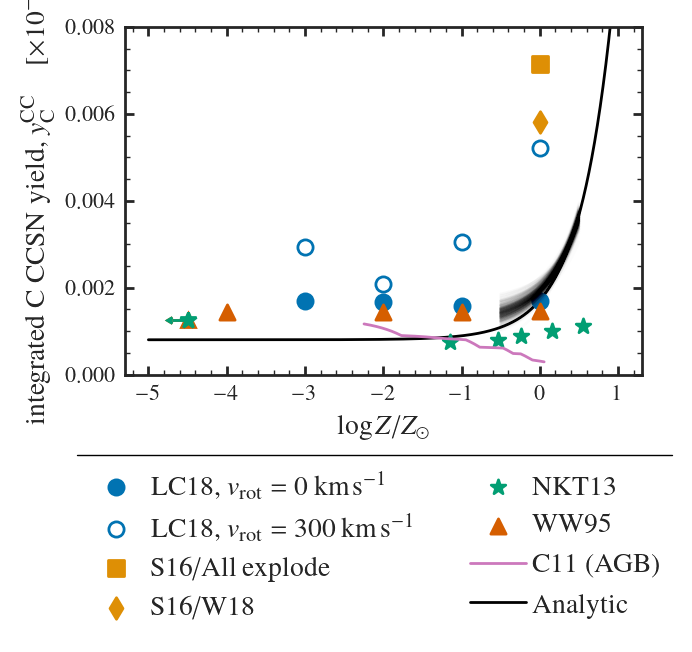

In [35]:
fig, ax = plt.subplots()


# left panel
plt.sca(ax)

plot_y_cc()
plot_c11()

plot_analy()
# plot AGB line
plot_y_cc_mcmc(samples)
#plt.yscale("log")

lab = plt.xlabel(r"$\log Z/Z_{\odot}$")

y_scale = 1e4
plt.ylabel(r"integrated C CCSN yield, $y_{\rm C}^{\rm CC}\quad [\times 10^{-4}]$")

plt.ylim(0, 0.008)

lines, labs = axs[0].get_legend_handles_labels()

    
leg = fig.legend(lines, labs, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=2)
box1 = leg.get_tightbbox()
box2 = lab.get_tightbbox() 


t1 = box1.transformed(fig.transFigure.inverted())
t2 = box2.transformed(fig.transFigure.inverted())
ym = (t2.y0 + t1.y1)/2


# plt.legend(handles =l, bbox_to_anchor=(0,-0.2), loc="upper left")
fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))

plt.savefig("figures/cc_yields.pdf")

# Other elements

## Does wind matter?

/tmp/ipykernel_1604763/1646264211.py:13: ScienceWarning: The Nomoto, Kobayashi & Tominaga (2013), ARA&A, 51, 457 study did not separate wind and explosive yields (or did not report wind yields), publishing only the total yields. For this reason, this calculation can only run including the wind yield.
  y2 = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/ipykernel_1604763/1646264211.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/ipykernel_1604763/1646264211.py:13: ScienceWarning: The Woosley & Weaver (1995) ApJ, 101, 181 study did not separate wind and explosive yields (or did not report wind yields), publishing only the total yields. For this reason, this calculation can only run including the wind yield.
  y2 = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metali

Text(0, 0.5, 'wind fraction for C')

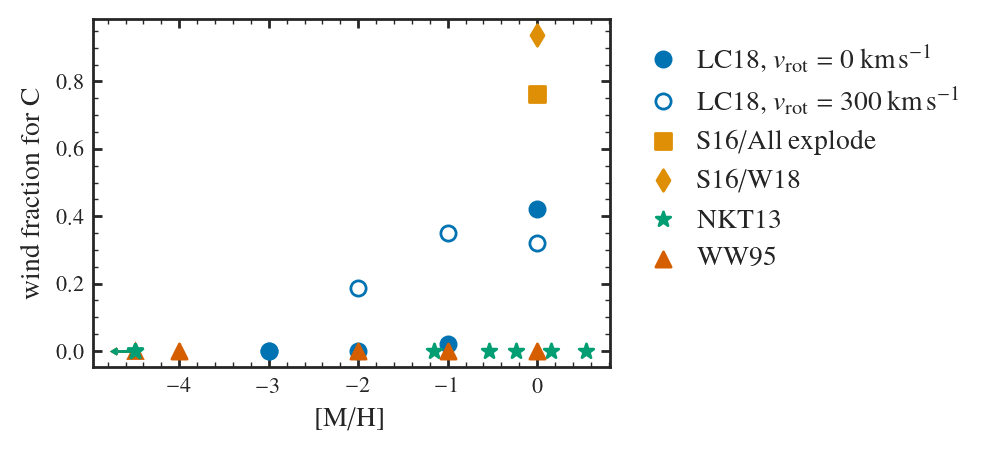

In [15]:
def plot_y_cc_wind_frac(ele='c', ele2=None, **kwargs):
    for i in range(N):
        study=ccsne_studies[i]
        metalicities = allowed_MoverH[study]
        m_upper = M_max[study]

        rotation = rotations[i]

        y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
             for metalicity in metalicities]

        y2 = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper, **kwargs)[0]
             for metalicity in metalicities]

        y = (y - np.array(y2)) / y

        marker = markers[i]
        color =facecolor= colors[i]
        label = labels[i]
        if np.isinf(metalicities[0]):
            if study == "WW95":
                x0 = -4.5
                y0 = -0.000
                ms = 5
                zorder = 2
            else:
                x0 = -4.5
                y0 = 0
                ms = 6
                zorder = 3
            plt.errorbar(x0, y[0] + y0, xerr=[0.2], fmt=marker, color=color, 
                         xuplims=[1],ms=ms, zorder=zorder, capsize=0)
            x = metalicities[1:]
            y = y[1:]
        else:
            x = metalicities

        if rotation == 150:
            facecolor=(1,1,1,0)
        if rotation == 300:
            facecolor=(1,1,1,0)

        plt.scatter(x, y, ec=color, label=label,
                    lw=1, fc=facecolor, 
                     marker=marker, s=sizes[i])

plot_y_cc_wind_frac(wind=False)
arya.Legend(-1)
plt.xlabel("[M/H]")
plt.ylabel("wind fraction for C")

In [16]:
ccsne = vice.yields.ccsne.settings

/tmp/ipykernel_1897181/2895073621.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,


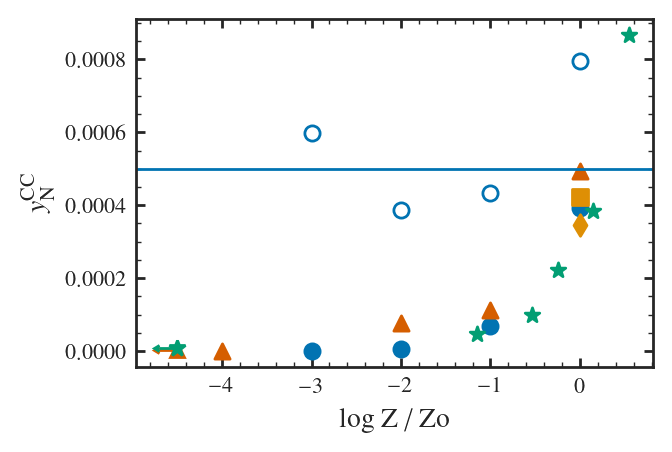

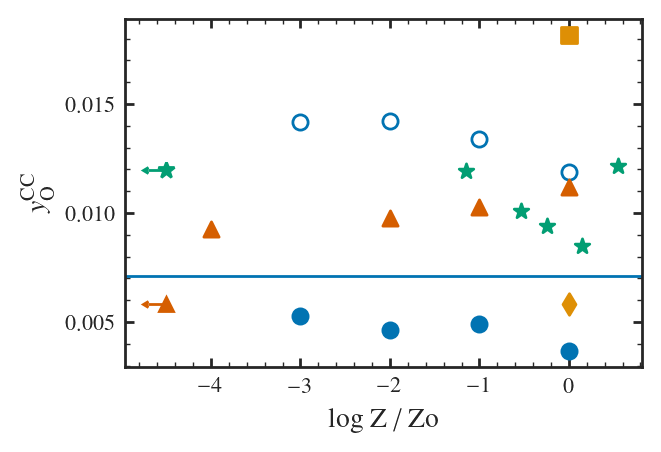

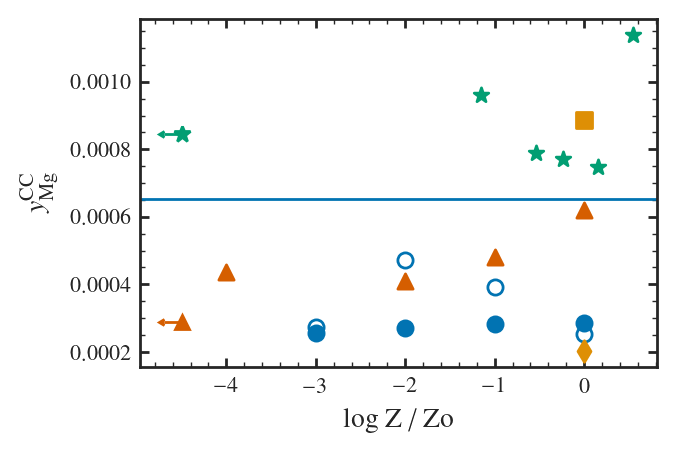

/tmp/ipykernel_1897181/2895073621.py:9: ScienceWarning: The Limongi & Chieffi (2018), ApJS, 237, 13 study published only the results which adopted a fixed yield of nickel-56, and these are the yields which are
installed in this version of VICE. For this reason, we caution the user on these yields of iron peak elements.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,


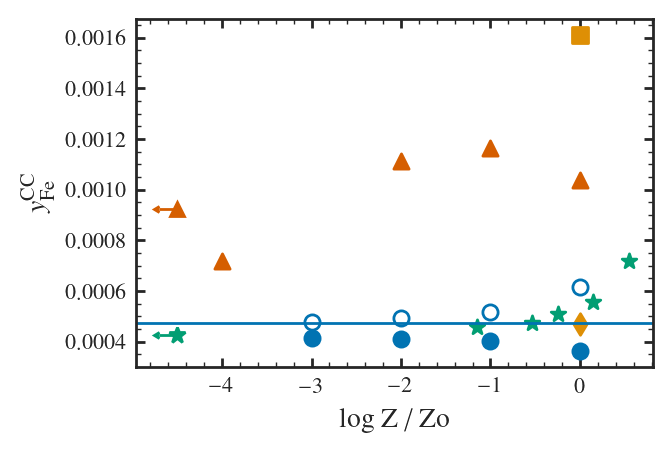

In [17]:
for ele in ["n", "o", "mg", "fe"]:
    plot_y_cc(ele)
    plt.xlabel("log Z / Zo")
    plt.ylabel(r"$y_{\rm %s}^{\rm CC}$" % ele.title())
    plt.axhline(ccsne[ele])
                                         
    plt.show()

In [18]:
surp.set_yields()

/tmp/ipykernel_1897181/2895073621.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/ipykernel_1897181/2895073621.py:13: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity,


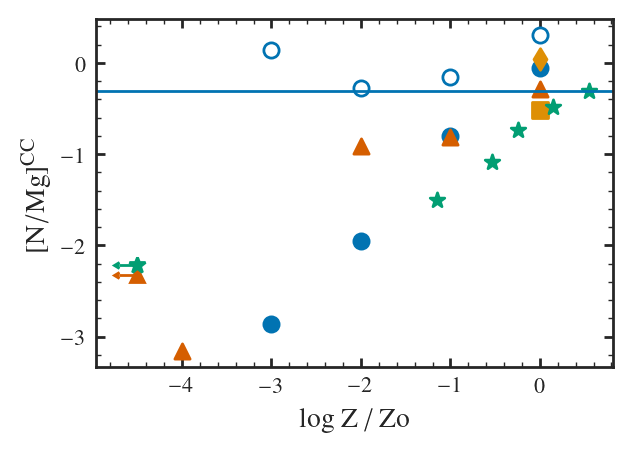

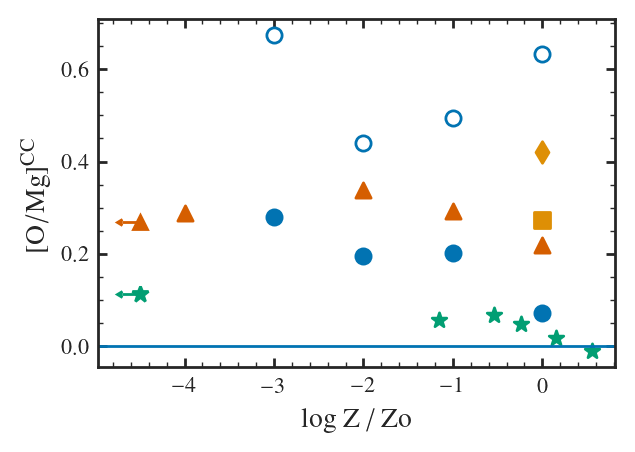

/tmp/ipykernel_1897181/2895073621.py:9: ScienceWarning: The Limongi & Chieffi (2018), ApJS, 237, 13 study published only the results which adopted a fixed yield of nickel-56, and these are the yields which are
installed in this version of VICE. For this reason, we caution the user on these yields of iron peak elements.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,


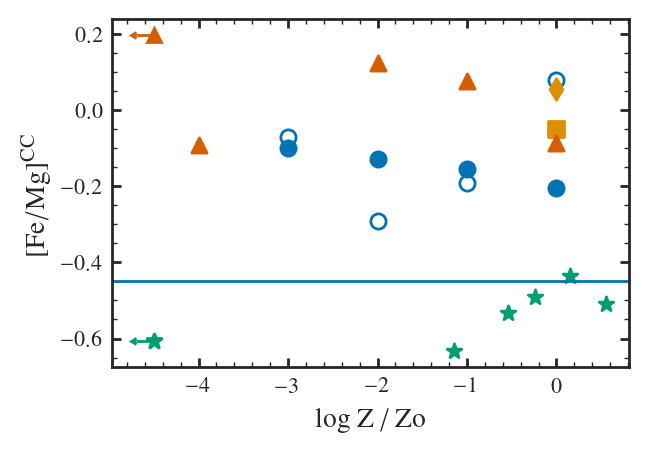

In [19]:
for ele in ["n", "o", "fe"]:
    plot_y_cc(ele,  "mg")
    plt.xlabel("log Z / Zo")
    plt.ylabel(r"$[{\rm %s / Mg}]^{\rm CC}$" % ele.title())

    plt.axhline(gcem.abund_ratio_to_brak(ccsne[ele] / ccsne["mg"], ele, "mg"))
    plt.show()

/tmp/ipykernel_1897181/2895073621.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/ipykernel_1897181/2895073621.py:13: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity,


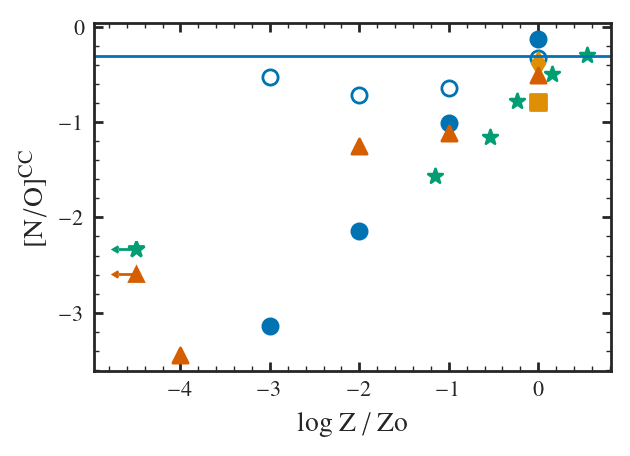

/tmp/ipykernel_1897181/2895073621.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/ipykernel_1897181/2895073621.py:13: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity,


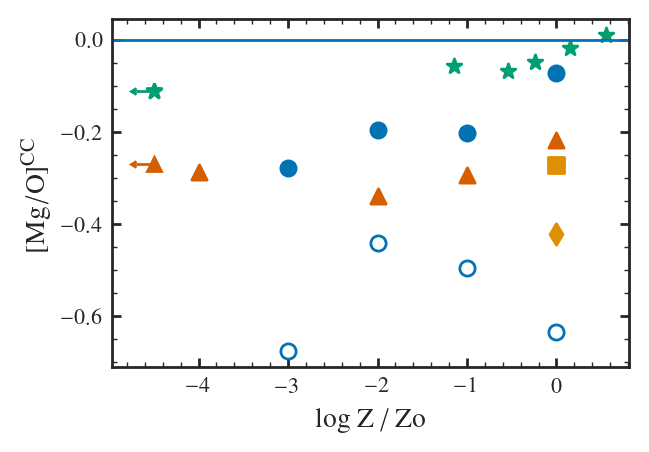

/tmp/ipykernel_1897181/2895073621.py:9: ScienceWarning: The Limongi & Chieffi (2018), ApJS, 237, 13 study published only the results which adopted a fixed yield of nickel-56, and these are the yields which are
installed in this version of VICE. For this reason, we caution the user on these yields of iron peak elements.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/ipykernel_1897181/2895073621.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/ipykernel_1897181/2895073621.py:13: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity,


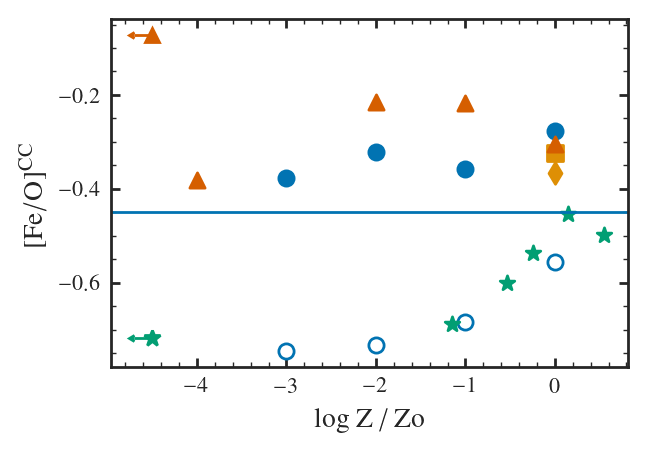

In [20]:
for ele in ["n", "mg", "fe"]:
    plot_y_cc(ele,  "o")
    plt.xlabel("log Z / Zo")
    plt.ylabel(r"$[{\rm %s / O}]^{\rm CC}$" % ele.title())

    plt.axhline(gcem.abund_ratio_to_brak(ccsne[ele] / ccsne["o"], ele, "o"))

    plt.show()